<a href="https://colab.research.google.com/github/thihanaung-thnn/TBXray_classification/blob/main/02_models_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
!unzip -qq /content/drive/MyDrive/Tensorflow/TB_classification/archive.zip

In [3]:
import os
import shutil
import pathlib
original_dir = pathlib.Path('TB_Chest_Radiography_Database')
new_base_dir = pathlib.Path('TB_Vs_Normal')

def make_subset(subset_name, start_n, end_n, start_tb, end_tb):

    dir_normal = new_base_dir / subset_name / 'Normal'
    dir_tb = new_base_dir / subset_name / 'Tuberculosis'
    os.makedirs(dir_normal)
    os.makedirs(dir_tb)
    
    fnames_n = [f"Normal-{i}.png" for i in range(start_n, end_n)]
    for fname in fnames_n:
        shutil.copyfile(src=original_dir / 'Normal' / fname, 
                       dst=dir_normal / fname)
    
    fnames_tb = [f"Tuberculosis-{i}.png" 
                for i in range(start_tb, end_tb)]
    for fname in fnames_tb:
        shutil.copyfile(src=original_dir / 'Tuberculosis' / fname, 
                       dst=dir_tb / fname)

make_subset('test', 2241+560, 2241+560+700, 449+112, 449+112+140)
make_subset('all', 1, 3501, 1, 701)

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMG_SHAPE = (224, 224, 3)

test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE
)

all_dataset = image_dataset_from_directory(
    new_base_dir / 'all', 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE
)

Found 840 files belonging to 2 classes.
Found 4200 files belonging to 2 classes.


## Load saved Models

In [5]:
dense201 = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/dense201.h5')
dense201_ft = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/dense201_finetune.h5')
mobn2 = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/mobn2.h5')
mobn2_ft = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/mobn2_finetune.h5')
resnet101 = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/resnet101.h5')
resnet101_ft = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/resnet101_finetune.h5')
resnet50 = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/resnet50.h5')
vgg16 = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/vgg16.h5')
vgg19 = load_model('/content/drive/MyDrive/Tensorflow/TB_classification/models/vgg19.h5')

In [6]:
def prediction(model_name, dataset, threshold=0.5):
    all_features, all_labels = [], []
    for images, labels in dataset:
        features = model_name.predict(images)
        all_features.append(features)
        all_labels.append(labels)

    all_features = np.concatenate(all_features) 
    preds = all_features > threshold
    y_true = np.concatenate(all_labels)

    return all_features, y_true

In [7]:
models = [dense201, dense201_ft, mobn2, mobn2_ft, resnet101, 
          resnet101_ft, resnet50, vgg16, vgg19]

model_names = ['DenseNet201', 'DenseNet201_fine_tuned', 'MobileNet_V2', 'MobileNet_V2_fine_tuned',
               'ResNet101', 'ResNet101_fine_tuned', 'ResNet50', 'VGG16', 'VGG19']

- Test dataset means the data that does not contain in model training. 
- All dataset means all the X-ray including training data, validation data and test data. 

- Test dataset has 700 normal X-rays and 140 TB X-rays.
- All dataset has 3500 normal X-rays and 700 TB X-rays. 

In [27]:
test_dataset_results = dict()
pred_probas_1 = dict()
for model, name in zip(models, model_names):
    test_dataset_results[name] = dict()
    y_preds_proba , y_true = prediction(model, test_dataset)
    pred_probas_1[name] = dict()
    pred_probas_1[name]['y_pred_proba'] = y_preds_proba
    pred_probas_1[name]['y_true'] = y_true
    
    y_preds = y_preds_proba > 0.5
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()

    test_dataset_results[name]['Accuracy'] = accuracy_score(y_true, y_preds)
    test_dataset_results[name]['Recall_score'] = recall_score(y_true, y_preds)
    test_dataset_results[name]['Precision_score'] = precision_score(y_true, y_preds)
    test_dataset_results[name]['Sensitivity'] = tp / (tp+fn)
    test_dataset_results[name]['Specificity'] = tn / (tn+fp)
    test_dataset_results[name]['F1_score'] = f1_score(y_true, y_preds)
    test_dataset_results[name]['AUC_score'] = roc_auc_score(y_true, y_preds_proba)

In [21]:
test_results = pd.DataFrame(test_dataset_results).transpose()
test_results.sort_values(by='F1_score', ascending=False)

,Accuracy,Recall_score,Precision_score,Sensitivity,Specificity,F1_score,AUC_score
VGG16,0.995238,0.992857,0.978873,0.992857,0.995714,0.985816,0.999827
ResNet50,0.995238,0.985714,0.985714,0.985714,0.997143,0.985714,0.999806
DenseNet201,0.994048,0.992857,0.972028,0.992857,0.994286,0.982332,0.999847
DenseNet201_fine_tuned,0.991667,1.000000,0.952381,1.000000,0.990000,0.975610,0.999908
ResNet101_fine_tuned,0.991667,0.978571,0.971631,0.978571,0.994286,0.975089,0.999704
ResNet101,0.990476,0.978571,0.964789,0.978571,0.992857,0.971631,0.999449
VGG19,0.990476,0.942857,1.000000,0.942857,1.000000,0.970588,0.999541
MobileNet_V2_fine_tuned,0.979762,0.950000,0.930070,0.950000,0.985714,0.939929,0.996000
MobileNet_V2,0.979762,0.935714,0.942446,0.935714,0.988571,0.939068,0.996031


In [25]:
all_dataset_results = dict()
pred_probas_2 = dict()
for model, name in zip(models, model_names):
    all_dataset_results[name] = dict()
    y_preds_proba , y_true = prediction(model, all_dataset)
    pred_probas_2[name] = dict()
    pred_probas_2[name]['y_pred_proba'] = y_preds_proba
    pred_probas_2[name]['y_true'] = y_true
    y_preds = y_preds_proba > 0.5
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()

    all_dataset_results[name]['Accuracy'] = accuracy_score(y_true, y_preds)
    all_dataset_results[name]['Recall_score'] = recall_score(y_true, y_preds)
    all_dataset_results[name]['Precision_score'] = precision_score(y_true, y_preds)
    all_dataset_results[name]['Sensitivity'] = tp / (tp+fn)
    all_dataset_results[name]['Specificity'] = tn / (tn+fp)
    all_dataset_results[name]['F1_score'] = f1_score(y_true, y_preds)
    all_dataset_results[name]['AUC_score'] = roc_auc_score(y_true, y_preds_proba)    

In [26]:
all_results = pd.DataFrame(all_dataset_results).transpose()
all_results.sort_values(by='F1_score', ascending=False)

,Accuracy,Recall_score,Precision_score,Sensitivity,Specificity,F1_score,AUC_score
DenseNet201,0.997381,0.992857,0.991441,0.992857,0.998286,0.992148,0.999183
VGG19,0.996190,0.980000,0.997093,0.980000,0.999429,0.988473,0.999843
ResNet50,0.995714,0.991429,0.983003,0.991429,0.996571,0.987198,0.999846
ResNet101_fine_tuned,0.995476,0.990000,0.982979,0.990000,0.996571,0.986477,0.999211
DenseNet201_fine_tuned,0.995000,0.995714,0.974825,0.995714,0.994857,0.985159,0.999466
VGG16,0.994286,0.995714,0.970752,0.995714,0.994000,0.983075,0.999771
ResNet101,0.994286,0.990000,0.976056,0.990000,0.995143,0.982979,0.999112
MobileNet_V2,0.989048,0.967143,0.967143,0.967143,0.993429,0.967143,0.997974
MobileNet_V2_fine_tuned,0.988810,0.978571,0.955370,0.978571,0.990857,0.966831,0.998047


## Confusion Matrix For Test X-rays

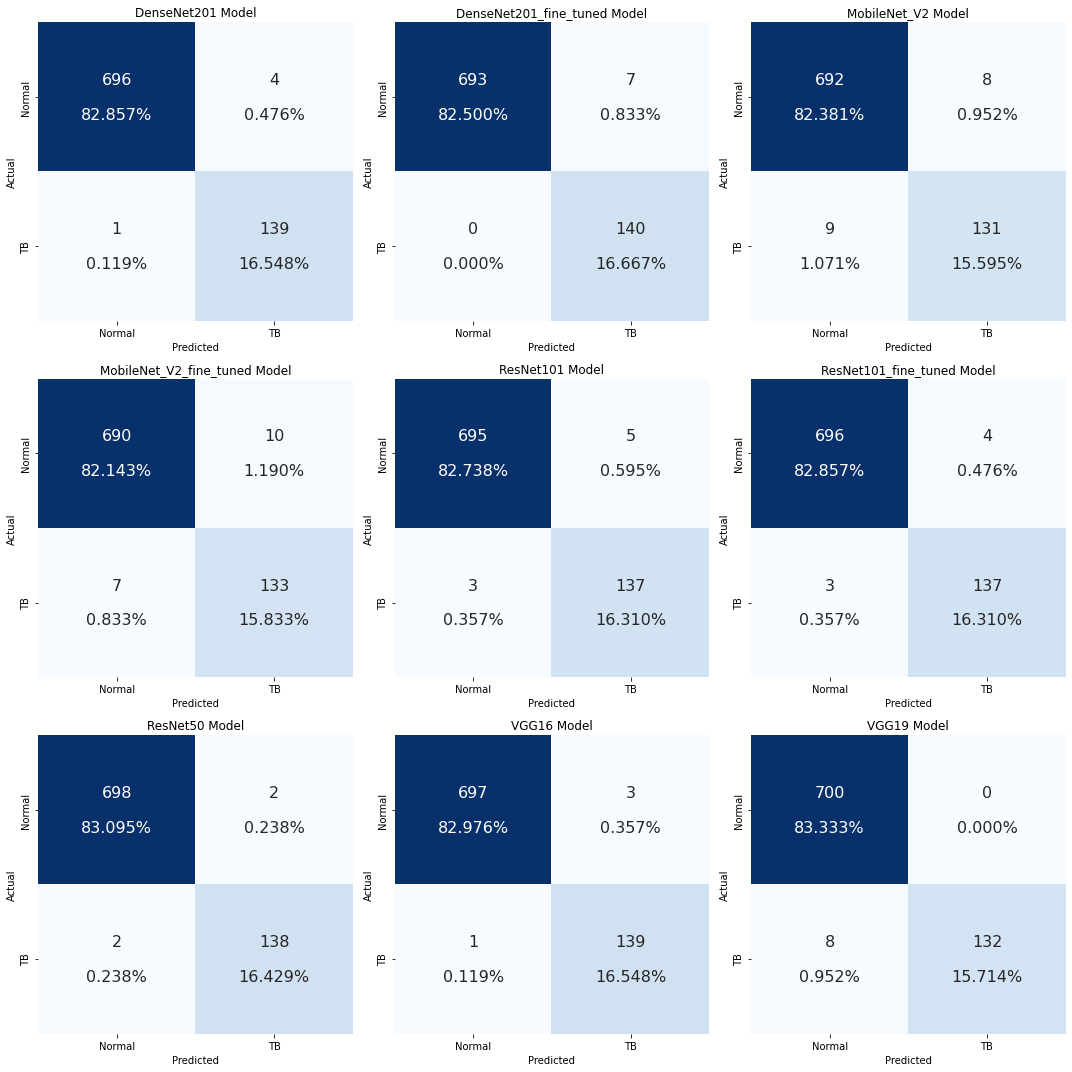

In [73]:
plt.figure(figsize=(15,15))
for i, name in enumerate(model_names):
    cm = confusion_matrix(pred_probas_1[name]['y_true'], pred_probas_1[name]['y_pred_proba'] > 0.5)
    counts = [str(value) for value in cm.flatten()]
    percents = ["{0:.3%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(counts, percents)]
    labels = np.asarray(labels).reshape(2,2)
    cm_df = pd.DataFrame(cm)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.subplot(3,3,i+1)
    sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', 
            annot_kws={'size':16}, 
            yticklabels=['Normal', 'TB'],
            xticklabels=['Normal', 'TB'], 
            cbar=False)
    plt.title(f"{name} Model")
plt.tight_layout()

## Confusion Matrix For All X-rays

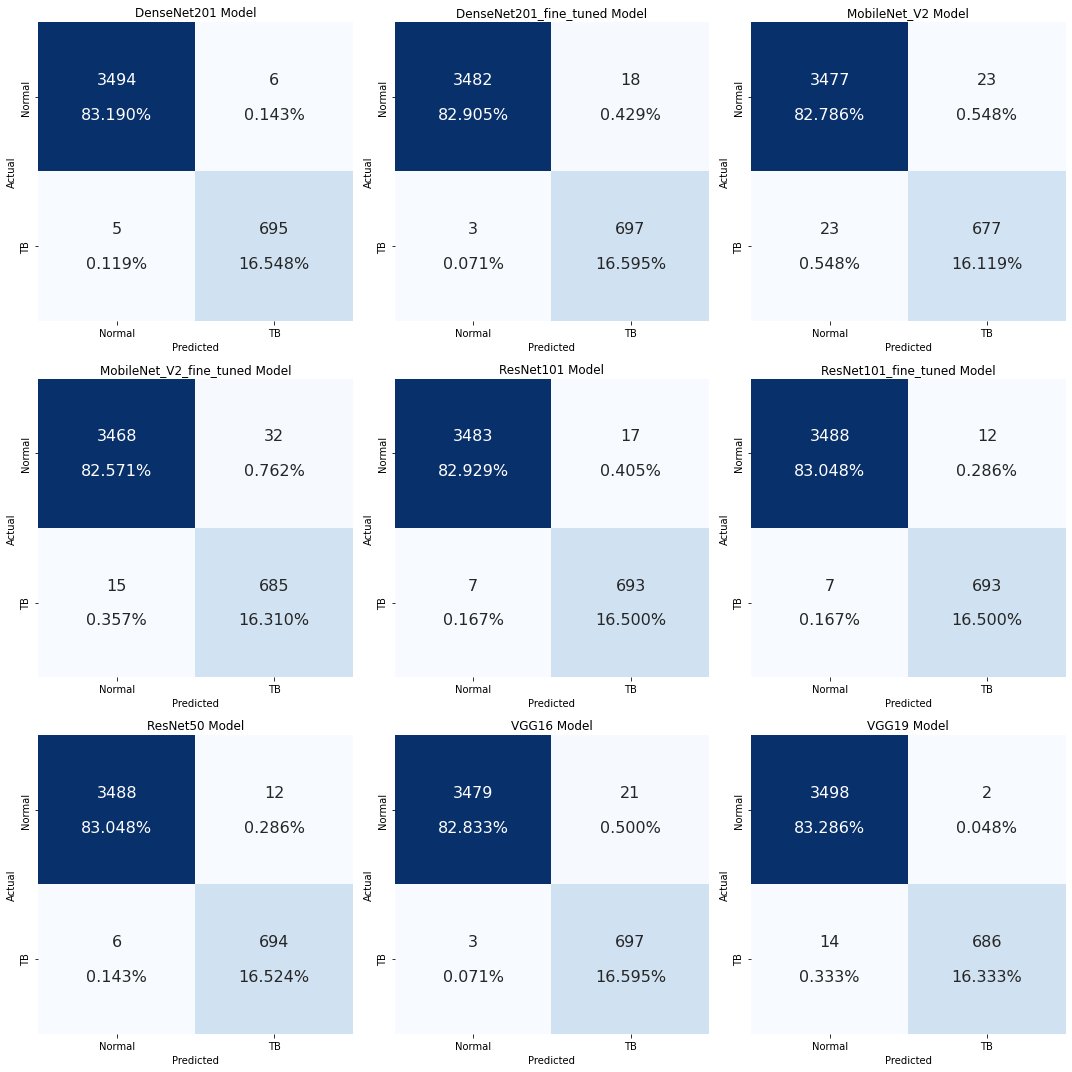

In [74]:
plt.figure(figsize=(15,15))
for i, name in enumerate(model_names):
    cm = confusion_matrix(pred_probas_2[name]['y_true'], pred_probas_2[name]['y_pred_proba'] > 0.5)
    counts = [str(value) for value in cm.flatten()]
    percents = ["{0:.3%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(counts, percents)]
    labels = np.asarray(labels).reshape(2,2)
    cm_df = pd.DataFrame(cm)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.subplot(3,3,i+1)
    sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues', 
            annot_kws={'size':16}, 
            yticklabels=['Normal', 'TB'],
            xticklabels=['Normal', 'TB'], 
            cbar=False)
    plt.title(f"{name} Model")
plt.tight_layout()